# ¿Podemos detectar patrones entre consumidores específicos para identificar posibles fraudes?

In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
import sklearn_extensions as ske
#from sklearn_extensions.fuzzy_kmeans import KMedians, FuzzyKMeans
#%matplotlib notebook

## Introduccion

**Contexto comercial.** Usted trabaja para el equipo de fraude en una gran compañía de seguros que se ocupa de la emisión de pólizas de seguro para varios tipos de reclamos tanto para individuos como para empresas. Se realiza un seguimiento de las pólizas que se emiten y se examina y evalúa cualquier reclamo presentado para determinar la legitimidad y la aprobación final para el pago por parte de la compañía de seguros. Sin embargo, muchas personas intentan aprovecharse presentando reclamos bajo falsos pretextos para obtener ingresos adicionales. El papel del equipo de fraude es determinar qué reclamos presentados deben aprobarse y cuáles deben denegarse.

**Problema comercial.** Su tarea es responder a la siguiente pregunta: **"¿Existen patrones particulares en los grupos de reclamaciones presentadas que puedan ser indicativos de fraude?"**

**Contexto analítico.** El equipo de contabilidad le ha proporcionado datos sobre todas las reclamaciones recientes realizadas por 1000 personas. A diferencia de los casos anteriores, los datos aquí estarán sin etiquetar; es decir, no existe una variable que nos diga cuáles de estas afirmaciones son fraudulentas o no. Como resultado, los modelos de clasificación que hemos estado usando hasta ahora no se pueden usar, y en su lugar debemos usar **modelos de agrupamiento** para abordar este problema de **aprendizaje no supervisado**.

El caso está estructurado de la siguiente manera: 1) realizaremos un análisis exploratorio de datos para investigar visualmente la estructura de los datos; 2) usar estas observaciones para guiar nuestra metodología de agrupamiento y ajustar los modelos apropiados; 3) discutir las ventajas y limitaciones de los métodos típicos de agrupamiento; y finalmente 4) segmentar y generar conclusiones sobre clusters particulares.

## Exploracion de data

In [2]:
df_data = pd.read_excel('insurance_data_1000.xlsx')
df_data.head(5)

,case_id,income,age,sex,approval,fraud,claims
0,59982,35750.95,42,M,Approved,Under Review,9518.95
1,87249,24078.27,19,M,Denied,No,19354.23
2,50406,39241.52,37,M,Denied,Fraud,13056.04
3,59391,33248.31,26,M,Approved,No,19238.37
4,96622,38649.96,54,M,Approved,No,14427.42


In [3]:
#Seleccionar las variables de interes
df_new = df_data[['case_id','income','age','claims']]
df_new.head(5)

,case_id,income,age,claims
0,59982,35750.95,42,9518.95
1,87249,24078.27,19,19354.23
2,50406,39241.52,37,13056.04
3,59391,33248.31,26,19238.37
4,96622,38649.96,54,14427.42


A continuación, echemos un vistazo al conjunto de reclamos bajo revisión y cómo se distribuyen:

C:\Users\Windows\AppData\Local\Temp\ipykernel_60136\4215047887.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, bins=20, kde=False, fit=norm)


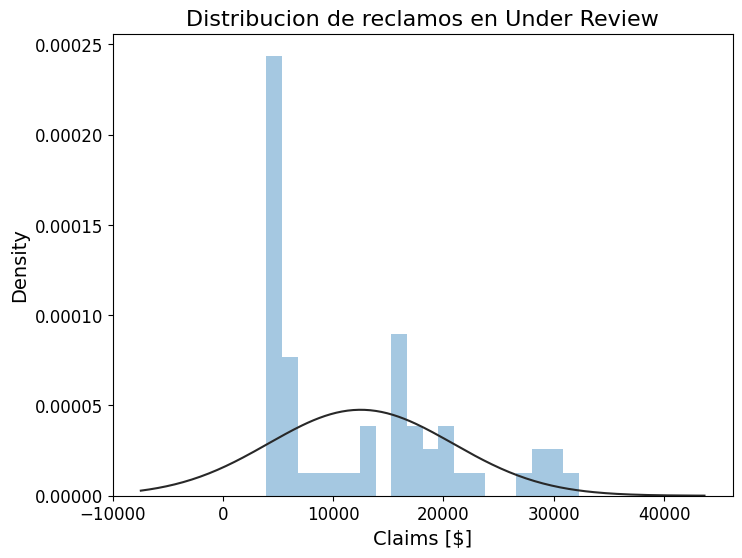

In [4]:
#%matplotlib inline
plt.figure(figsize=(8,6))
df_frauds=df_data[df_data['fraud']=='Under Review']
x=df_frauds['claims']
sns.distplot(x, bins=20, kde=False, fit=norm)
plt.title('Distribucion de reclamos en Under Review', fontsize=16)
plt.xlabel('Claims [$]', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

Esta es una distribución realmente extraña. Parece que hay tres conjuntos de picos para los montos de las reclamaciones. Intentemos ver algunos diagramas de dispersión 2D de "reclamos" y "edad" frente a "ingresos" para la población de muestra, a fin de obtener más información sobre lo que está sucediendo:

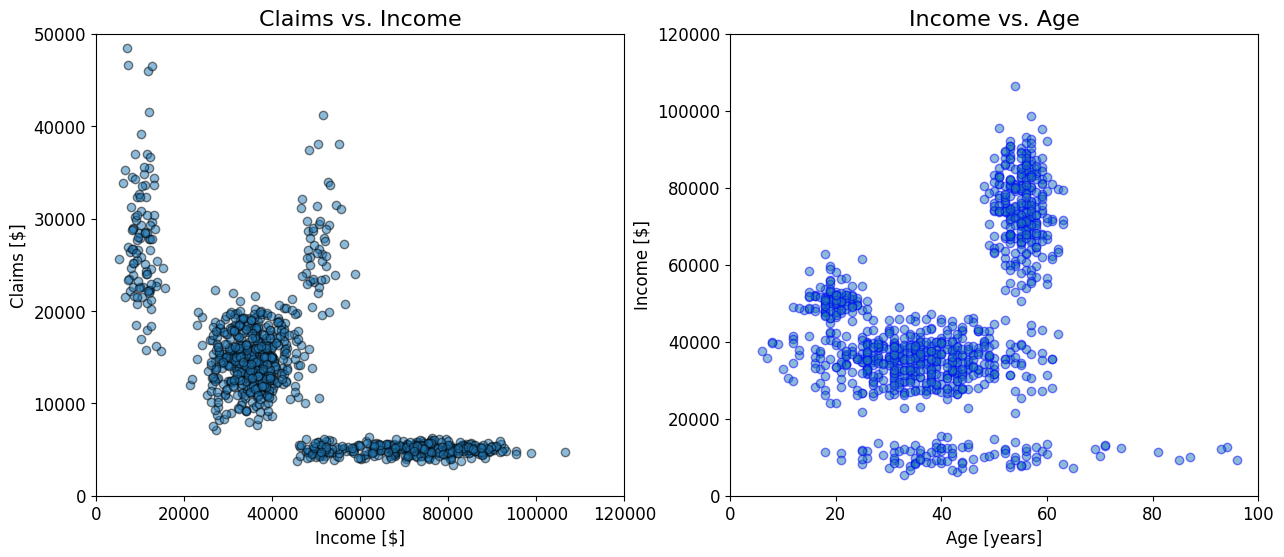

In [5]:
#%matplotlib inline
f = plt.figure(figsize=(15,6))
fig = plt.subplot(121)
plt.scatter(df_new['income'], df_new['claims'], edgecolor='k', alpha=0.5)
plt.ylim(0, 50000)
plt.yticks(fontsize=12)
plt.ylabel('Claims [$]', fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.title('Claims vs. Income', fontsize=16)

fig = plt.subplot(122)
plt.scatter(df_new['age'],df_new['income'], edgecolor='b', alpha=0.5)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age', fontsize=16)

plt.show()

También podemos estratificar nuestros datos por género antes de realizar las visualizaciones anteriores:

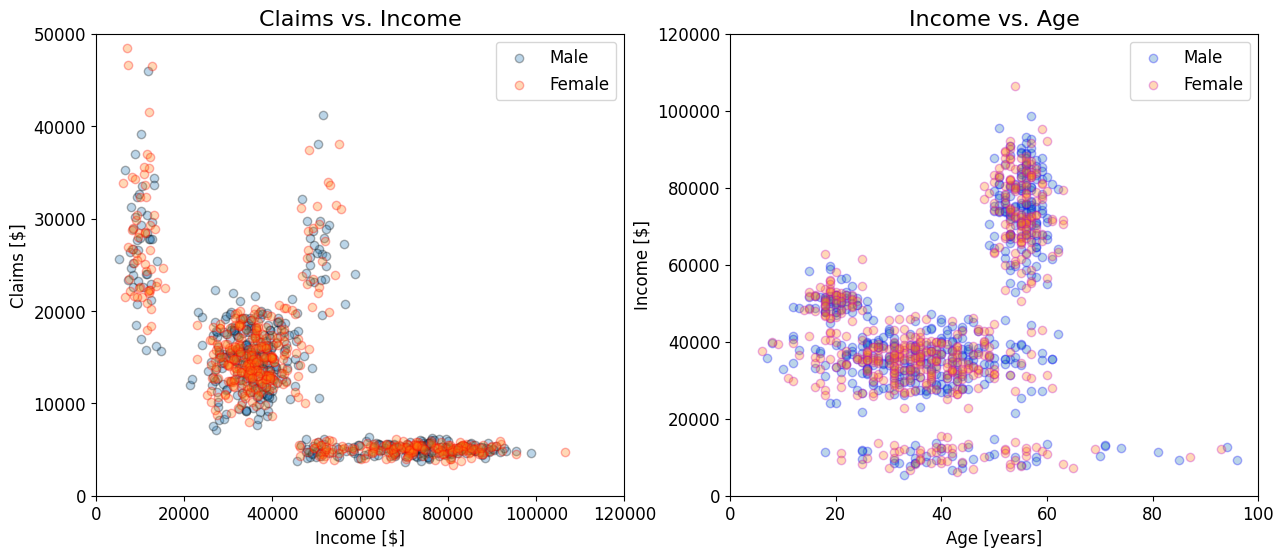

In [6]:
#%matplotlib inline
df_gender = df_data[['case_id','income','age','claims','sex']]
df_male = df_gender[df_gender['sex']=="M"]
df_female = df_gender[df_gender['sex']=="F"]

f = plt.figure(figsize=(15,6))
fig = plt.subplot(121)
plt.scatter(df_male['income'], df_male['claims'], edgecolor='k', alpha=0.3, label="Male")
plt.scatter(df_female['income'], df_female['claims'], edgecolor='r', alpha=0.3, label="Female")
plt.legend(loc='best', fontsize=12)
plt.ylim(0, 50000)
plt.ylabel('Claims [$]', fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Claims vs. Income', fontsize=16)

fig = plt.subplot(122)
plt.scatter(df_male['age'],df_male['income'], edgecolor='b', alpha=0.3, label="Male")
plt.scatter(df_female['age'],df_female['income'], edgecolor='m', alpha=0.3, label="Female")
plt.legend(loc='best', fontsize=12)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.title('Income vs. Age', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Ejercicio 1

¿Qué patrones notas en las gráficas de arriba? ¿Por qué crees que esto podría estar sucediendo?

**Respuesta.** No parece haber grandes diferencias en las distribuciones basadas en el género; sin embargo, las gráficas agnósticas de género muestran algunos grupos claros. Por ejemplo, hay un grupo gigante de reclamos alrededor del rango de ingresos de \\$30,000 - \\$40,000 en el gráfico de reclamos frente a ingresos, lo que podría deberse al hecho de que el ingreso medio es de aproximadamente \\$30,000 - \\$40,000. También hay una franja de reclamos de \\$50,000 - \\$100,000 en el gráfico de reclamos frente a ingresos, que tienen un valor de \\$5,000 aproximadamente. No está claro exactamente cuáles son estos reclamos, pero podrían ser cosas cotidianas con las que las personas más ricas pueden lidiar (por ejemplo, reclamos por accidentes automovilísticos). También hay una franja de reclamos por al menos \\$20,000 entre personas que solo ganan \\$10,000, lo cual es inusual y bien puede consistir en reclamos fraudulentos.

En el gráfico de ingresos frente a edad, hay una franja de personas que ganan \\$10 000 en todas las edades (salario mínimo), un gran grupo de personas que ganan entre \\$30 000 - \\$40 000 en todas las edades (salario medio) y un muchas personas de mayores ingresos (\\$60,000 - \\$100,0000) justo antes de los 60 años. A los 59 años y medio es cuando las personas en los EE. UU. pueden comenzar a sacar ahorros de sus cuentas de jubilación, por lo que esto puede tener algo que ver con este patrón.



## $k$-means clustering 

En nuestras visualizaciones anteriores, parece que existen distintas poblaciones de individuos en función de las relaciones entre las reclamaciones y los ingresos, y los ingresos y la edad. Sin embargo, solo hemos logrado investigar dos relaciones de esta manera, y en conjuntos de datos más grandes con muchas funciones, hacerlo manualmente en todas las variables puede llevar mucho tiempo. Afortunadamente, los **modelos de agrupamiento** nos permiten resumir y detectar relaciones potencialmente interesantes con bastante rapidez.

Hay muchas variaciones de agrupación, pero la más común, y la que veremos, se llama **$k$-means clustering**. Este algoritmo separa el conjunto de datos dado en $k$ grupos que minimizan la suma de los cuadrados de las distancias entre cada par de puntos en el grupo. El científico de datos debe preseleccionar el valor de $k$, lo que puede requerir un análisis previo para determinarlo.

El método tiene 3 pasos generales, que se pueden resumir de la siguiente manera:

1. Inicialización. Para comenzar, se deben seleccionar $k$ puntos (no necesariamente ninguno de los puntos de datos, solo puntos en el mismo espacio dimensional) como los centroides "iniciales".
2. Asignación. Cada punto de datos se asigna al grupo correspondiente al centroide más cercano a sí mismo (según la distancia euclidiana estándar).
3 Actualización. Una vez que todos los puntos de datos se han asignado a sus respectivos conglomerados, se calcula un nuevo centroide para cada conglomerado tomando la media de todos los puntos en ese conglomerado.

### Ejercicio 2

$k$: el agrupamiento de medios se basa en minimizar la distancia euclidiana entre los puntos de datos. ¿Qué tipo de problemas podría plantear esto en términos de los resultados que obtenemos? ¿Cómo podemos arreglar esto?

**Respuesta.** Hay un problema de escala que podría ocurrir. Si algunas variables naturalmente tienen valores muy pequeños mientras que otras tienen valores muy grandes, entonces las características no se ponderan de manera uniforme en el cálculo de la distancia euclidiana. Para arreglar esto, necesitaríamos escalar cada variable apropiadamente por una medida de su tamaño; por ejemplo, podríamos dividir todo por el valor de la mediana de dicha variable.

Hay muchas formas de escalar, o **normalizar**, las variables, una de las cuales hemos mencionado anteriormente. La mejor opción de normalización depende de los detalles particulares del conjunto de datos en cuestión.

De manera similar, la distancia euclidiana es la métrica más utilizada para calcular los clústeres, ya que es bastante fácil de calcular y funciona bien en la mayoría de los conjuntos de datos, pero no es la única. Los científicos de datos a veces usan variaciones en la métrica de distancia según el conjunto de datos que están investigando. Por lo tanto, es un parámetro que debe ser considerado y explorado durante la etapa de EDA para determinar qué es lo mejor para proceder.

### Ejercicio 3

Escriba una función que normalice `edad`, `ingresos` y `reclamaciones` de acuerdo con los valores mínimo y máximo de cada variable. Por ejemplo, si estamos hablando de `edad`, entonces un valor normalizado para una edad $A$ se calcularía como $\displaystyle\frac {X - min(age)} {max(age) - min(age)}$.( metodo de escalamiento min-max)

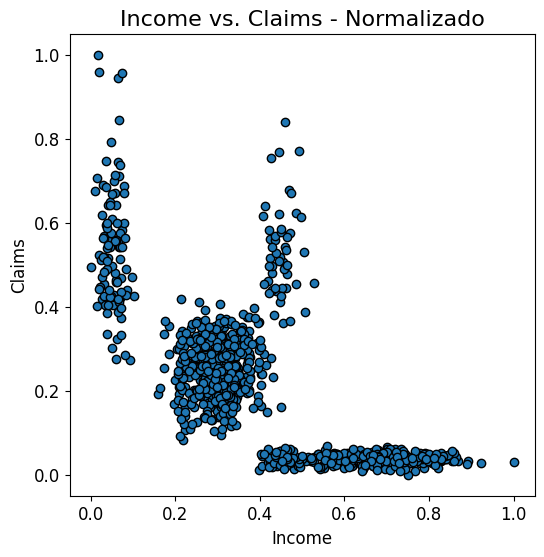

In [7]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)
    return result

# Crear el nuevo dataframe con la data normalizada
df_new_1 = normalize(df_new[['age','income','claims']])

plt.figure(figsize=(6, 6))
plt.scatter(df_new_1['income'], df_new_1['claims'], edgecolor='k')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.title('Income vs. Claims - Normalizado', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Los métodos que se muestran arriba transformarán los datos de tal manera que la magnitud de todas las características sea aproximadamente similar. Sin embargo, puede haber un método de escalado diferente que permita que la agrupación en clústeres $k$-means funcione mejor. La mejor elección del método de escalado depende de los datos específicos proporcionados.

### Ejercicio 4

Imagine una situación en la que, además de nuestro conjunto de datos original, hubiera algunas personas con altos ingresos que también presentaran reclamos de alto valor. ¿Qué podría salir mal con nuestro método de escalado anterior? ¿Cómo podrías lidiar con esto?

**Respuesta.** Estos puntos de datos se presentarían en la parte superior derecha de nuestro gráfico de reclamaciones frente a ingresos y, por lo general, ocurrirían una sola vez (es decir, no con frecuencia). Sin embargo, afectarían significativamente nuestro método de escalado mínimo-máximo (al igual que los valores atípicos afectan significativamente los modelos de regresión) y, por lo tanto, nuestro proceso de agrupación.

Una solución sería omitir estos puntos de datos, ya que no ocurren con demasiada frecuencia (una explicación plausible es que los datos pueden haberse ingresado accidentalmente con un 0 adicional, por lo tanto, inflando sus valores). Sin embargo, eliminar puntos de datos de la consideración es algo no tan conveniente y una opción peligrosa que generalmente no queremos usar si podemos evitarlo. En general, nos gustaría utilizar procedimientos de escalado más robustos que naturalmente puedan tratar con tales valores atípicos.


Tracemos también el gráfico normalizado de edad frente a reclamos. Tenga en cuenta que este tiene 3 grupos notables en lugar de 4:

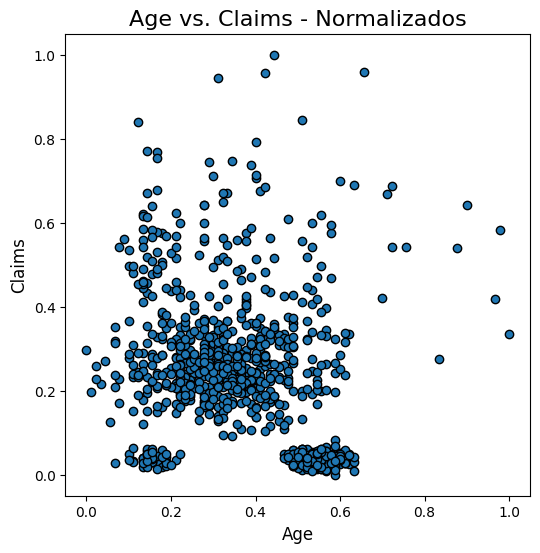

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(df_new_1['age'], df_new_1['claims'], edgecolor='k')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.title('Age vs. Claims - Normalizados', fontsize=16)
plt.show()

## Inicializacion de clusters

Con base en los datos normalizados, podemos hacer una suposición educada de que tenemos 4 grupos:

1. altos ingresos y bajos reclamos
2. ingresos moderados y reclamos moderados
3. ingresos moderados y siniestros elevados
4. bajos ingresos y altos reclamos

Investiguemos más a fondo para determinar si esta es la mejor manera de agrupar los datos. Debemos comenzar inicializando los primeros valores de los centroides:

Centroides iniciales (income, claims) son: 
 {1: [0.5, -1.0], 2: [0.5, 0.25], 3: [0.5, 0.25], 4: [1.0, 0.25]}


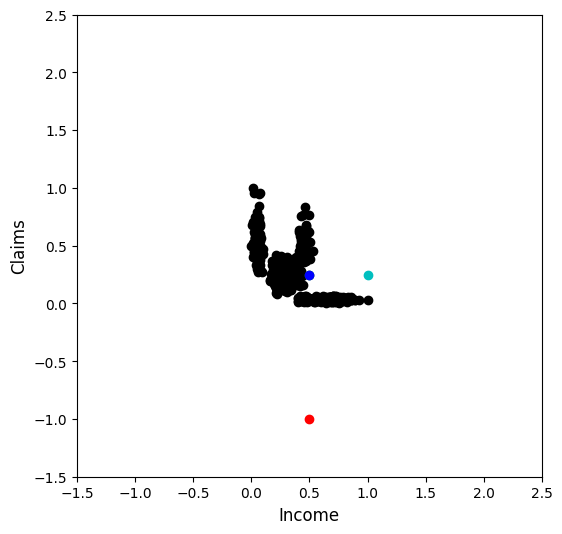

In [9]:

# Definicion de grupos
k = 4

# Eleccion manual de coordenadas
data_range_x = [-1,-0.5,0.5,1]
data_range_y = [-1,-0.25,0.25,1]

centroids = {i+1: [np.random.choice(data_range_x), 
                   np.random.choice(data_range_y)] for i in range(k)}

print("Centroides iniciales (income, claims) son: \n" ,
      centroids)
fig = plt.figure(figsize=(6, 6))
plt.scatter(df_new_1['income'], df_new_1['claims'], color='k')
colour_map_1 = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colour_map_1[i])
plt.xlabel('Income', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.show()

Aquí hemos implementado una inicialización cruda de los medios del clúster, pero el paquete `KMeans` de `sklearn` ya tiene la inicialización predeterminada para el método más óptimo: "k-means++". Trabajaremos con esto de aquí en adelante.

### Implementation of $k$-means using `sklearn` (5 mts)

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


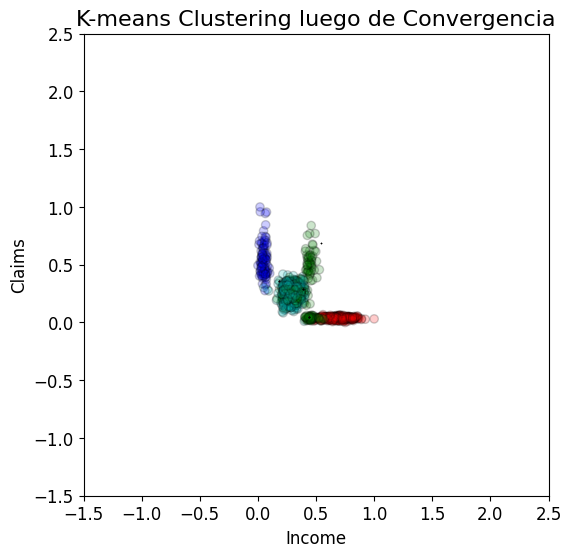

In [10]:
#%matplotlib inline
k = 4
kmeans = KMeans(n_clusters=k,init='k-means++')
kmeans.fit(df_new_1)

# Proceso iterativo para encontrar centorides 
labels = kmeans.predict(df_new_1)
centroids = kmeans.cluster_centers_

# Plot de los datos
colour_map_1 = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y', 6:'w'}
fig = plt.figure(figsize=(6, 6))
colors = [colour_map_1[x+1] for x in labels]

plt.scatter(df_new_1['income'], df_new_1['claims'], color=colors, alpha=0.2, edgecolor='k')

for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colour_map_1[idx+1], marker='*', edgecolor='k')  # , s=150)
    
plt.xlabel('Income', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('K-means Clustering luego de Convergencia', fontsize=16)
plt.show()

## Eleccion del valor optimo de $k$

Aunque el análisis visual sugiere que $k = 4$ es el valor óptimo, es una buena práctica verificar esto cuantitativamente en lugar de simplemente mirarlo a simple vista. (Esto es especialmente importante cuando se agrupan datos que no se pueden visualizar fácilmente, algo común con datos multidimensionales complejos).

### Ejercicio 5

¿Cómo podría construir un método cuantitativo para determinar el $k$ óptimo?

**Respuesta.** Dado que el algoritmo $k$-means minimiza la suma de cuadrados dentro de cada grupo, esta es la función objetivo con la que debemos comparar todos los valores posibles de $k$. Podemos construir un gráfico lineal que muestre cómo cambia esta suma de cuadrados a medida que cambia $k$, luego seleccionamos el valor de $k$ con el valor más bajo.

Sin embargo, este método no funciona del todo: imagine el caso en el que tiene la misma cantidad de grupos como puntos de datos. Entonces, la suma de los cuadrados es obviamente cero, ¡pero difícilmente se podría argumentar que tal agrupación es una buena idea! Por lo tanto, es prudente agregar un término de penalización (similar a cómo la métrica AIC contiene un término de penalización) correspondiente al valor de $k$. Esto permitirá que nuestro gráfico toque fondo mucho antes de que $k$ se vuelva demasiado grande, ya que el beneficio incremental de agregar solo un clúster más disminuye a medida que crece $k$, mientras que la penalización incremental aumenta.

El método descrito en el Ejercicio 5 es una forma de **regularización**; sin embargo, todavía no estamos listos para llegar allí. Por ahora, seremos un poco poco científicos al respecto, en lugar de eso, omitiremos el término de penalización y buscaremos el valor de $k$ en el gráfico lineal más allá del cual el cambio en la suma de los cuadrados es efectivamente insignificante. Esto se llama el *método del codo*.

### Ejercicio 6

Implemente el esquema del método del codo que describimos anteriormente. ¿Parece correcta nuestra suposición inicial de $k$?

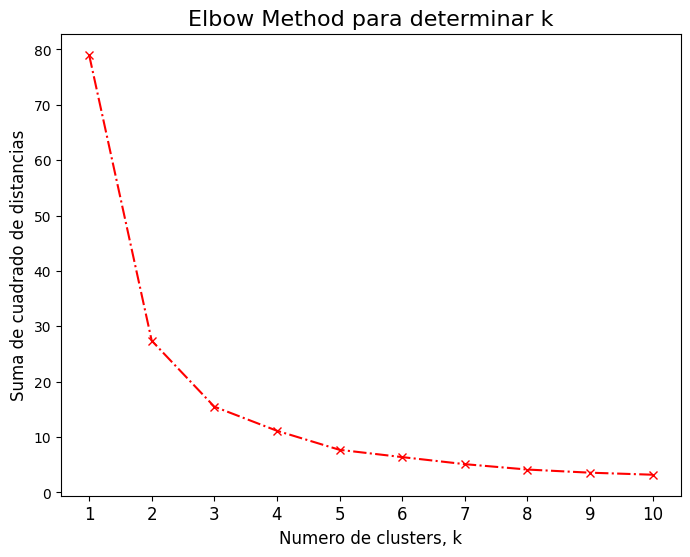

In [12]:
import warnings
warnings.filterwarnings("ignore")
sum_sq_d = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_new_1[['income','claims']])
    sum_sq_d.append(km.inertia_)
plt.figure(figsize=(8,6))
plt.plot(K, sum_sq_d, 'rx-.')
plt.xlabel('Numero de clusters, k', fontsize=12)
plt.ylabel('Suma de cuadrado de distancias', fontsize=12)
plt.title('Elbow Method para determinar k', fontsize=16)
plt.xticks(range(1,11), fontsize=12)
plt.show()

A partir del gráfico, parecería que el valor de agregar más clústeres realmente comienza a disminuir alrededor de $k = 3$. $k = 4$ está muy cerca de eso, por lo que podemos decir que nuestra suposición inicial fue correcta (es bastante común que nuestra suposición visual y el resultado del método anterior sean ligeramente diferentes).

### Ejercicio 7:

Dados los cuatro grupos de reclamos que identificamos con base en el cuadro de ingresos frente a reclamos, y teniendo en cuenta la información del cuadro de ingresos frente a edad, haga una sugerencia sobre lo que el departamento debe hacer con cada grupo.

**Respuesta.** Tenemos cuatro grupos. 

1. El primero son aquellos con altos ingresos y bajos reclamos, que probablemente sean reclamos ordinarios hechos por familias ricas. Es muy probable que estos no sean fraudulentos y que la empresa los acepte. 
2. El segundo son ingresos moderados con valores de reclamación moderados. Estos son bastante abundantes y podrían ser artículos cotidianos como reclamos de automóviles. Lo más probable es que debamos aceptarlos. 
3. El tercero son los ingresos moderados y los reclamos elevados. Esto podría ser plausible si es algo que las personas de ingresos medios necesitan pero que no siempre pueden pagar, como ciertos reclamos de salud. Así que probablemente deberíamos investigar esto más a fondo. 
4. La categoría final es ingresos bajos pero reclamos muy altos. Claramente, estos no son asequibles y, con la excepción de algo como los reclamos de salud, bien podrían ser intentos de obtener dinero gratis. Lo más probable es que debamos rechazarlos.

### Ejercicio 8

Dado lo que ha aprendido sobre el algoritmo $k$-means, ¿cuáles son algunos de los posibles inconvenientes cuando se aplica a conjuntos de datos?

Hay algunas deficiencias potenciales (estos son ejemplos, obviamente hay otras respuestas posibles):

1. El algoritmo $k$-means da más peso a los clústeres más grandes, ya que intenta minimizar la variación dentro del clúster, por lo que en los casos en que los clústeres naturalmente no tienen el mismo tamaño, esto podría generar resultados sesgados.
2. No necesariamente converge de manera uniforme o rápida, por lo que la elección de los puntos iniciales es sumamente importante. Este grado de dependencia no es necesariamente ideal.
3. Los valores atípicos pueden influir en gran medida en los datos y las medias del conglomerado, a menos que se utilice una métrica alternativa.

## Conclusiones

En este caso, dividimos con éxito el conjunto de datos en 4 grupos separados y validamos nuestra intuición con base en el agrupamiento de $k$-means. Aprendimos que hay muchas suposiciones integradas en el agrupamiento de $k$-medias (a saber, la elección de la métrica de distancia, la normalización y $k$) y que esto no puede automatizarse fácilmente, ya que estas opciones dependen del conjunto de datos particular en mano. Una vez que se han identificado los grupos individuales, la compañía de seguros ahora puede determinar qué reclamos investigar más a fondo o considerar inmediatamente como fraudulentos en función de algunos criterios adicionales.

## Para recordar

La agrupación en clústeres es una poderosa herramienta de aprendizaje no supervisada para investigar datos no etiquetados, particularmente para determinar patrones que no se conocían o entendían previamente. En el caso de grandes conjuntos de datos, se pueden identificar relaciones altamente complejas entre grupos de puntos de datos individuales que posiblemente no se podrían hacer a través del ojo humano.

## manual $k$-means implementacion y monitoreo

Aquí mostramos cómo funciona el algoritmo real $k$-means, desde la inicialización de los clústeres hasta los pasos de actualización y el resultado final:

Centroides iniciales (age, income) son: {1: [0.25, 0.25], 2: [-1.0, 0.5], 3: [-0.5, 0.25], 4: [-0.5, -0.5]}
        age    income    claims  distance_from_1  distance_from_2  \
0  0.400000  0.301264  0.137252             1.73             0.81   
1  0.144444  0.185900  0.355004             1.80             0.69   
2  0.344444  0.335762  0.215563             1.81             0.84   
3  0.222222  0.276530  0.352439             1.86             0.78   
4  0.533333  0.329915  0.245925             1.82             0.83   

   distance_from_3  distance_from_4  closest color  distancia_de_1  \
0             1.45             0.12        1     r            0.12   
1             1.46             0.12        1     r            0.12   
2             1.52             0.09        1     r            0.09   
3             1.53             0.11        1     r            0.11   
4             1.52             0.08        1     r            0.08   

   distancia_de_2  distancia_de_3  distancia_de_4  
0   

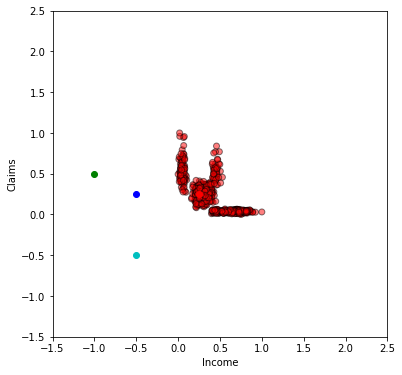

In [20]:
# Numero de grupos a usar
k = 4
# Initialization of cluster means 

centroids = {i+1: [np.random.choice([-1,-0.5,0.25,0.5]), 
                   np.random.choice([-1,-0.5,0.25,0.5])]
    for i in range(k)
}

print("Centroides iniciales (age, income) son:" ,
      centroids)

colour_map_1 = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}

def assignment(df, centroids):
    for i in centroids.keys():
        df['distancia_de_{}'.format(i)] = (
            np.sqrt(
                (df['income'] - centroids[i][0]) ** 2
                + (df['claims'] - centroids[i][1]) ** 2
            )
        ).round(2)
    centroid_distance_cols = ['distancia_de_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distancia_de_')))
    df['color'] = df['closest'].map(lambda x: colour_map_1[x])
    return df

df_2 = assignment(df_new_1, centroids)
print(df_2.head())

fig = plt.figure(figsize=(6, 6))
plt.scatter(df_2['income'], df_2['claims'], 
            color=df_2['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colour_map_1[i])
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 2.5)
plt.xlabel('Income')
plt.ylabel('Claims')
plt.show()

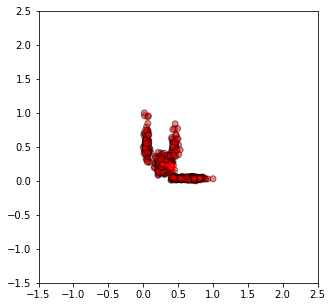

In [22]:
# Paso de actualización: en este paso, estamos actualizando la media, ahora calculándola en función de
# todos los puntos de datos que fueron asignados a ese grupo k-ésimo.

# Copie los valores anteriores y cree una nueva entrada llamada old_centroids.import copy
import copy
old_centroids = copy.deepcopy(centroids)

# Function to update the k-th clusters. 
def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df_2[df_2['closest'] == i]['income'])
        centroids[i][1] = np.mean(df_2[df_2['closest'] == i]['claims'])
    return k

centroids = update(centroids)
    
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.scatter(df_2['income'], df_2['claims'], 
            color=df_2['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colour_map_1[i])
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 2.5)

for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    ax.arrow(old_x, old_y, dx, dy, head_width=0.05, head_length=0.03, fc=colour_map_1[i], ec=colour_map_1[i])
plt.show()

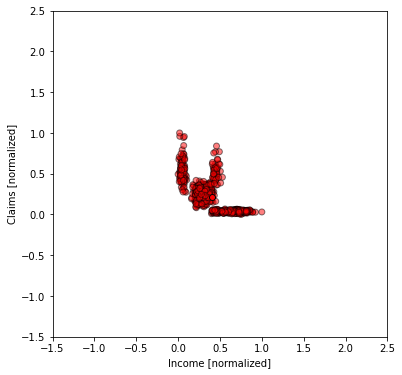

In [23]:
# Procedimiento iterativo: reasignar nuevos pesos
df_2 = assignment(df_2, centroids)

# Continue doing this until no new assignments have been made 
while True:
    closest_centroids = df_2['closest'].copy(deep=True)
    centroids = update(centroids)
    df_2 = assignment(df_2, centroids)
    if closest_centroids.equals(df_2['closest']):
        break

fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
plt.scatter(df_2['income'], df_2['claims'], 
            color=df_2['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colour_map_1[i], edgecolor='k')
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 2.5)
plt.xlabel('Income [normalized]')
plt.ylabel('Claims [normalized]')
plt.show()